# Saliency Maps
https://fairyonice.github.io/Saliency-Map-with-keras-vis.html

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

load model

In [72]:
import keras
from vis.utils import utils
from vis.visualization import visualize_saliency

# Load the model
model_name = 'model5'
yaml_file = open('multiscale_' + model_name + '_weights.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = keras.models.model_from_yaml(loaded_model_yaml)
# load weights into new model
model.load_weights('multiscale_' + model_name + '_weights.h5')

# Swap softmax with linear
model.layers[-1].activation = keras.activations.linear
model = utils.apply_modifications(model)

load data

In [73]:
X_data = np.load("X_data_fits.npy")
y_data = np.load("y_data_fits.npy")

maxmap_arr = np.max(X_data.reshape(X_data.shape[0],-1), axis = 1)
Xnorm = np.tile(maxmap_arr, (X_data.shape[1], X_data.shape[2], 1))
Xnorm = np.swapaxes(Xnorm, 0, 2)
X = X_data/Xnorm
X = X[..., np.newaxis]

y2d = y_data.copy()
y2d[:,0] = y_data[:,0]//20
idx = np.where(y2d[:,0]==5)[0]
y2d[idx,0] = 4
y2d[:,1] = y_data[:,1]//20
y = y2d[:,1]*5 + y2d[:,0]

# ypred = model.predict_classes(X)

### build-in saliency funtion

In [74]:
# grads.shape = (100,100,3)
# some mysterious conversion, in order to show nice color plot
# grads = visualize_saliency(model, -1, filter_indices=0, seed_input=X[0])

by hand

In [75]:
import keras.backend as K

def saliency_map(model, class_idx, seed_input):
    
    ## define derivative d loss / d layer_input
    layer_input       = model.input
    ## This model must already use linear activation for the final layer
    loss              = model.layers[-1].output[...,class_idx]
    grad_tensor       = K.gradients(loss,layer_input)[0]

    # ## create function that evaluate the gradient for a given input
    # # This function accept numpy array
    derivative_fn     = K.function([layer_input],[grad_tensor])

    # ## evaluate the derivative_fn
    grads = derivative_fn([seed_input[np.newaxis,...]])[0]
    grads = np.abs(grads).max(axis=(0,3))
    
    ## normalize to range between 0 and 1
    arr_min, arr_max  = np.min(grads), np.max(grads)
    grads = (grads - arr_min) / (arr_max - arr_min + K.epsilon())
    
    return grads

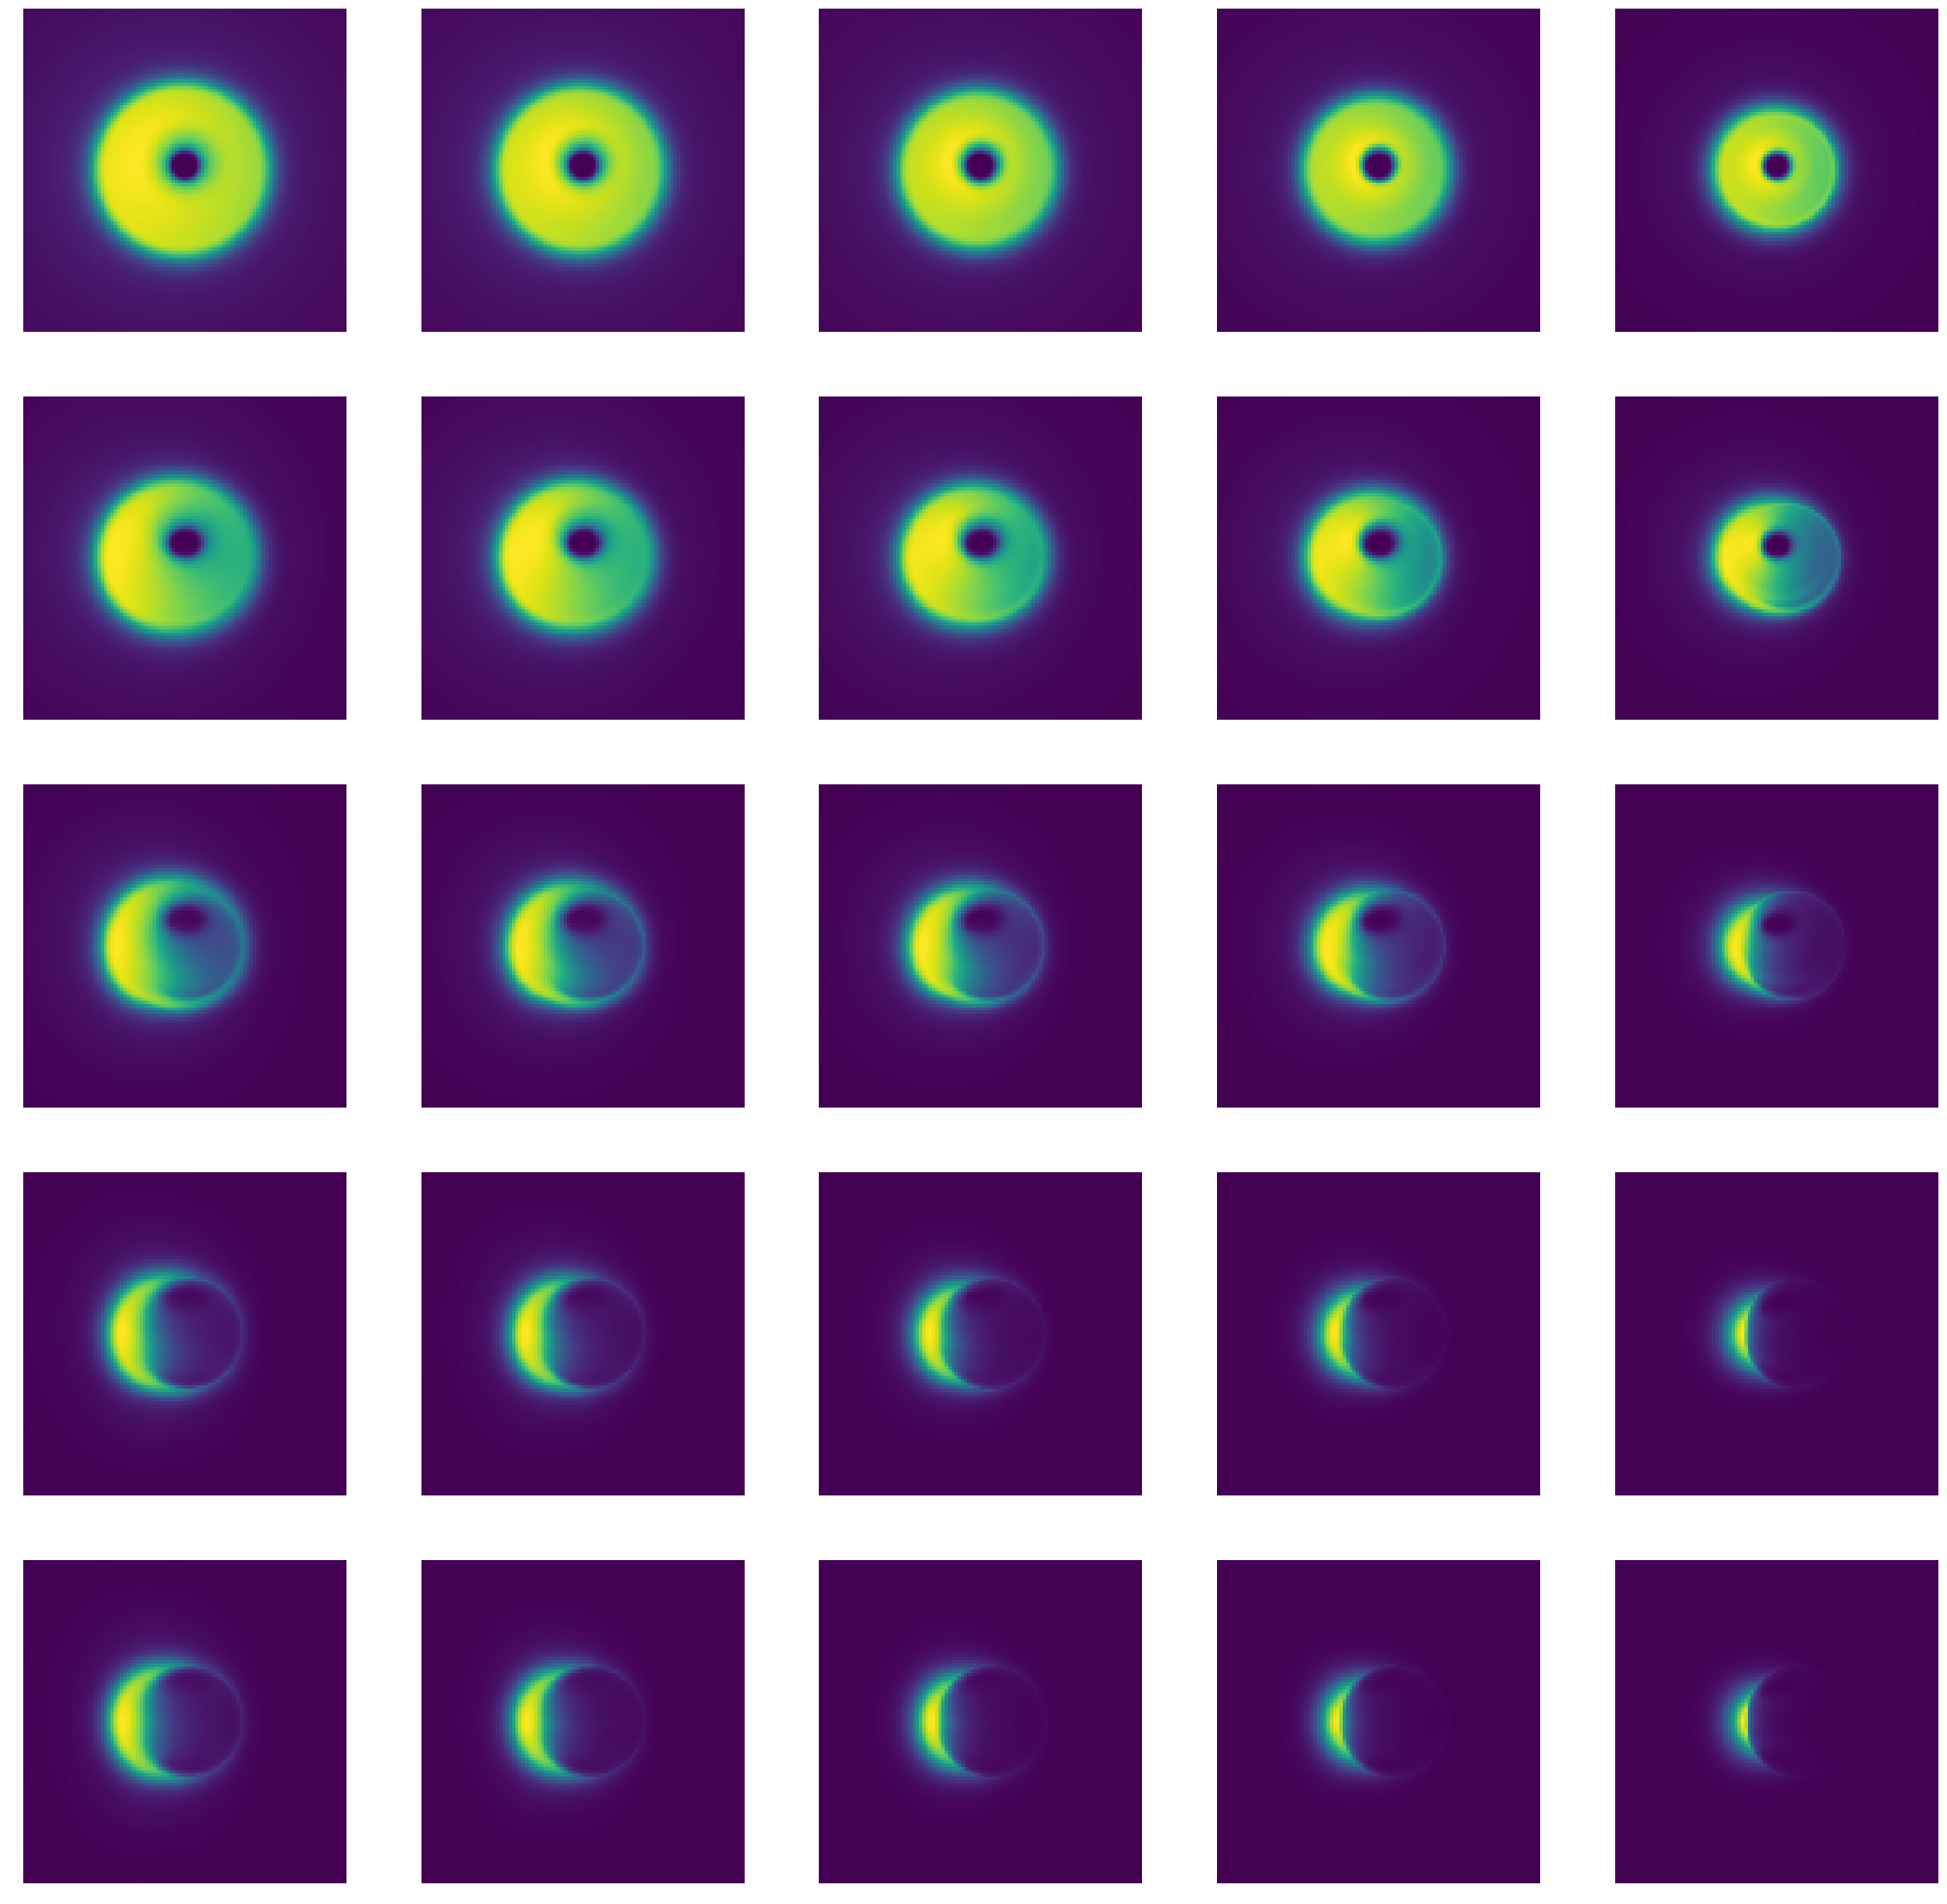

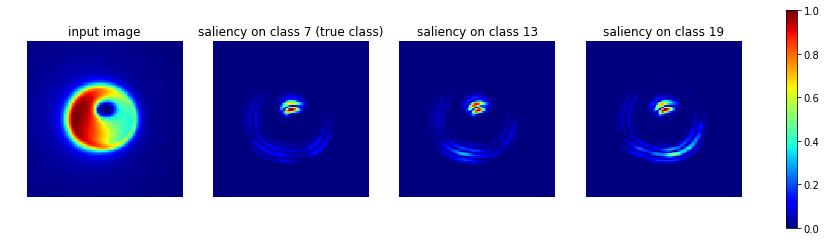

In [76]:
seed_idx = 3787

fig, ax = plt.subplots(1, 4, figsize=(16,4))
ax[0].imshow(X[seed_idx].reshape([100,100])/np.max(X), cmap='jet')
ax[0].set_title('input image')
ax[0].axis('off')

grads = saliency_map(model, y[seed_idx], X[seed_idx])
ax[1].imshow(grads, cmap='jet', vmin=0, vmax=1)
ax[1].set_title('saliency on class {} (true class)'.format(y[seed_idx]))
ax[1].axis('off')

grads = saliency_map(model, (y[seed_idx]+6)%25, X[seed_idx])
ax[2].imshow(grads, cmap='jet', vmin=0, vmax=1)
ax[2].set_title('saliency on class {}'.format((y[seed_idx]+6)%25))
ax[2].axis('off')

grads = saliency_map(model, (y[seed_idx]+12)%25, X[seed_idx])
p=ax[3].imshow(grads, cmap='jet')
ax[3].set_title('saliency on class {}'.format((y[seed_idx]+12)%25))
ax[3].axis('off')

fig.colorbar(p,ax=ax)
plt.show()

In [77]:
idxs = [int(x) for x in np.linspace(0,9089, 25)]
plt.figure(figsize=(40,40))
axs = []
for i, seed_idx in enumerate(idxs):
    ax1=plt.subplot(5, 5, i+1)
    p=ax1.imshow(X[seed_idx].reshape(100,100)/np.max(X), cmap='jet')
    plt.axis('off')
    axs.append(ax1)
cbar = fig.colorbar(p,ax=axs)
cbar.ax.tick_params(labelsize=30) 


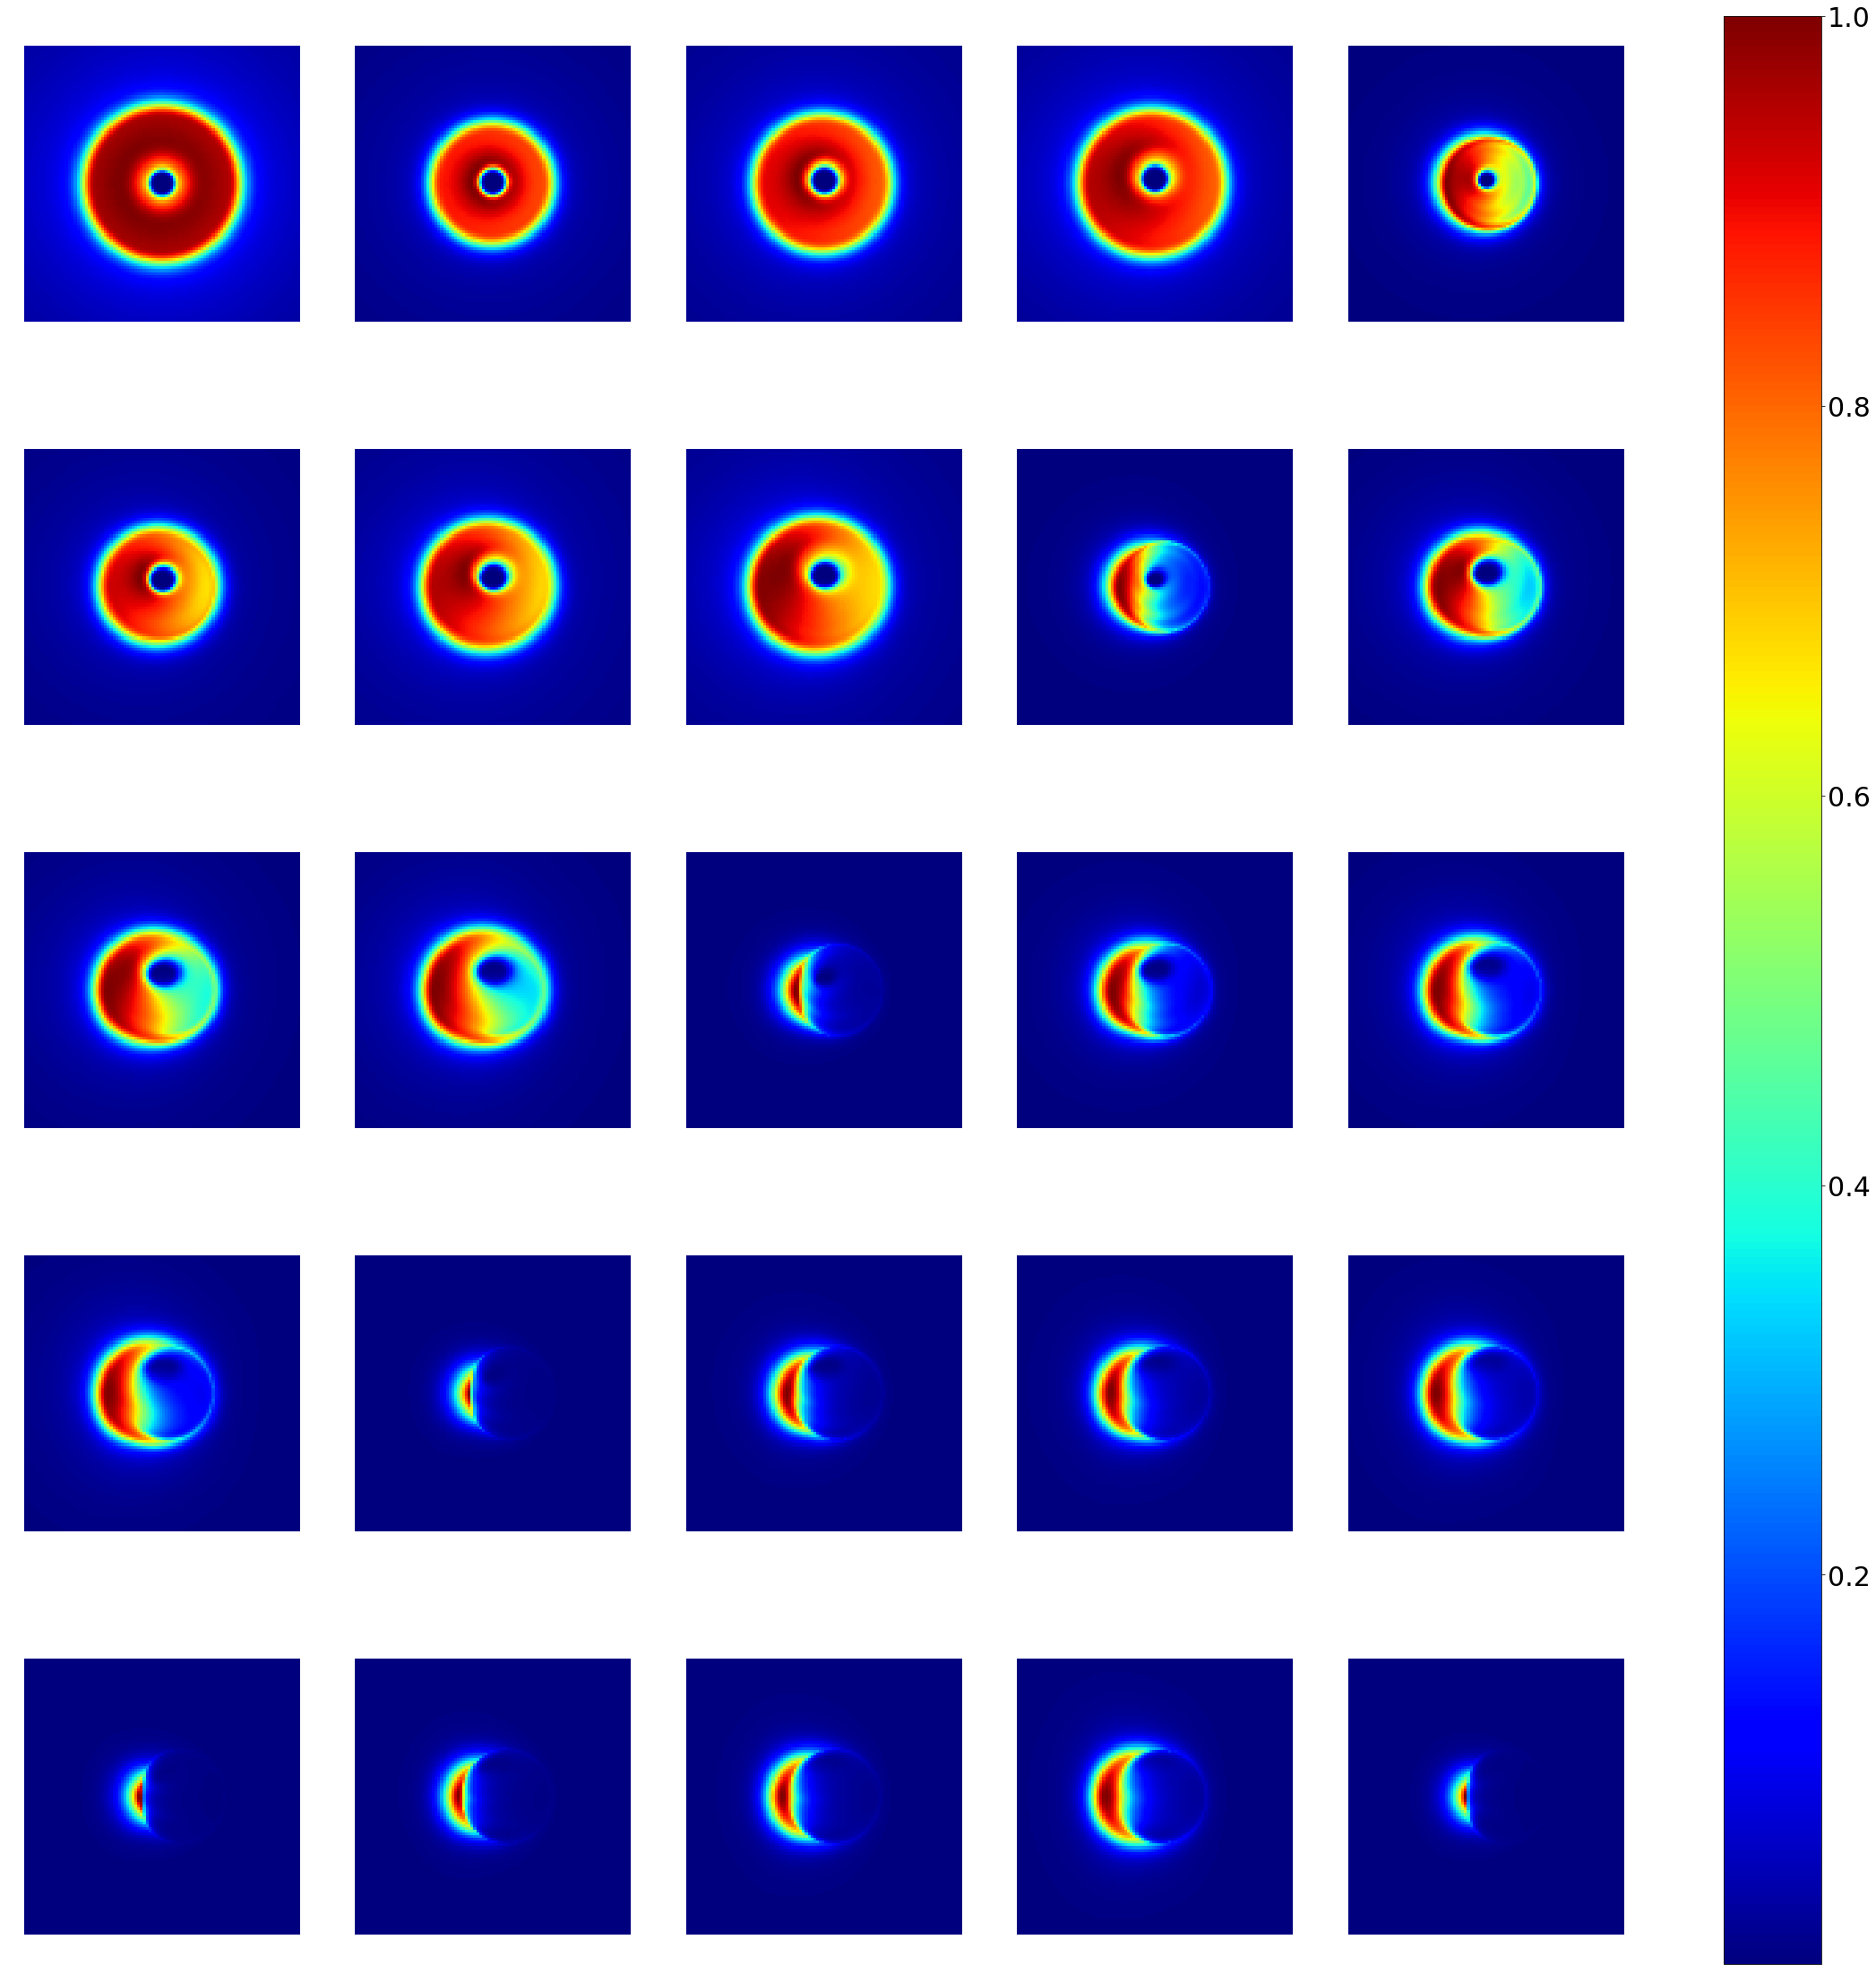

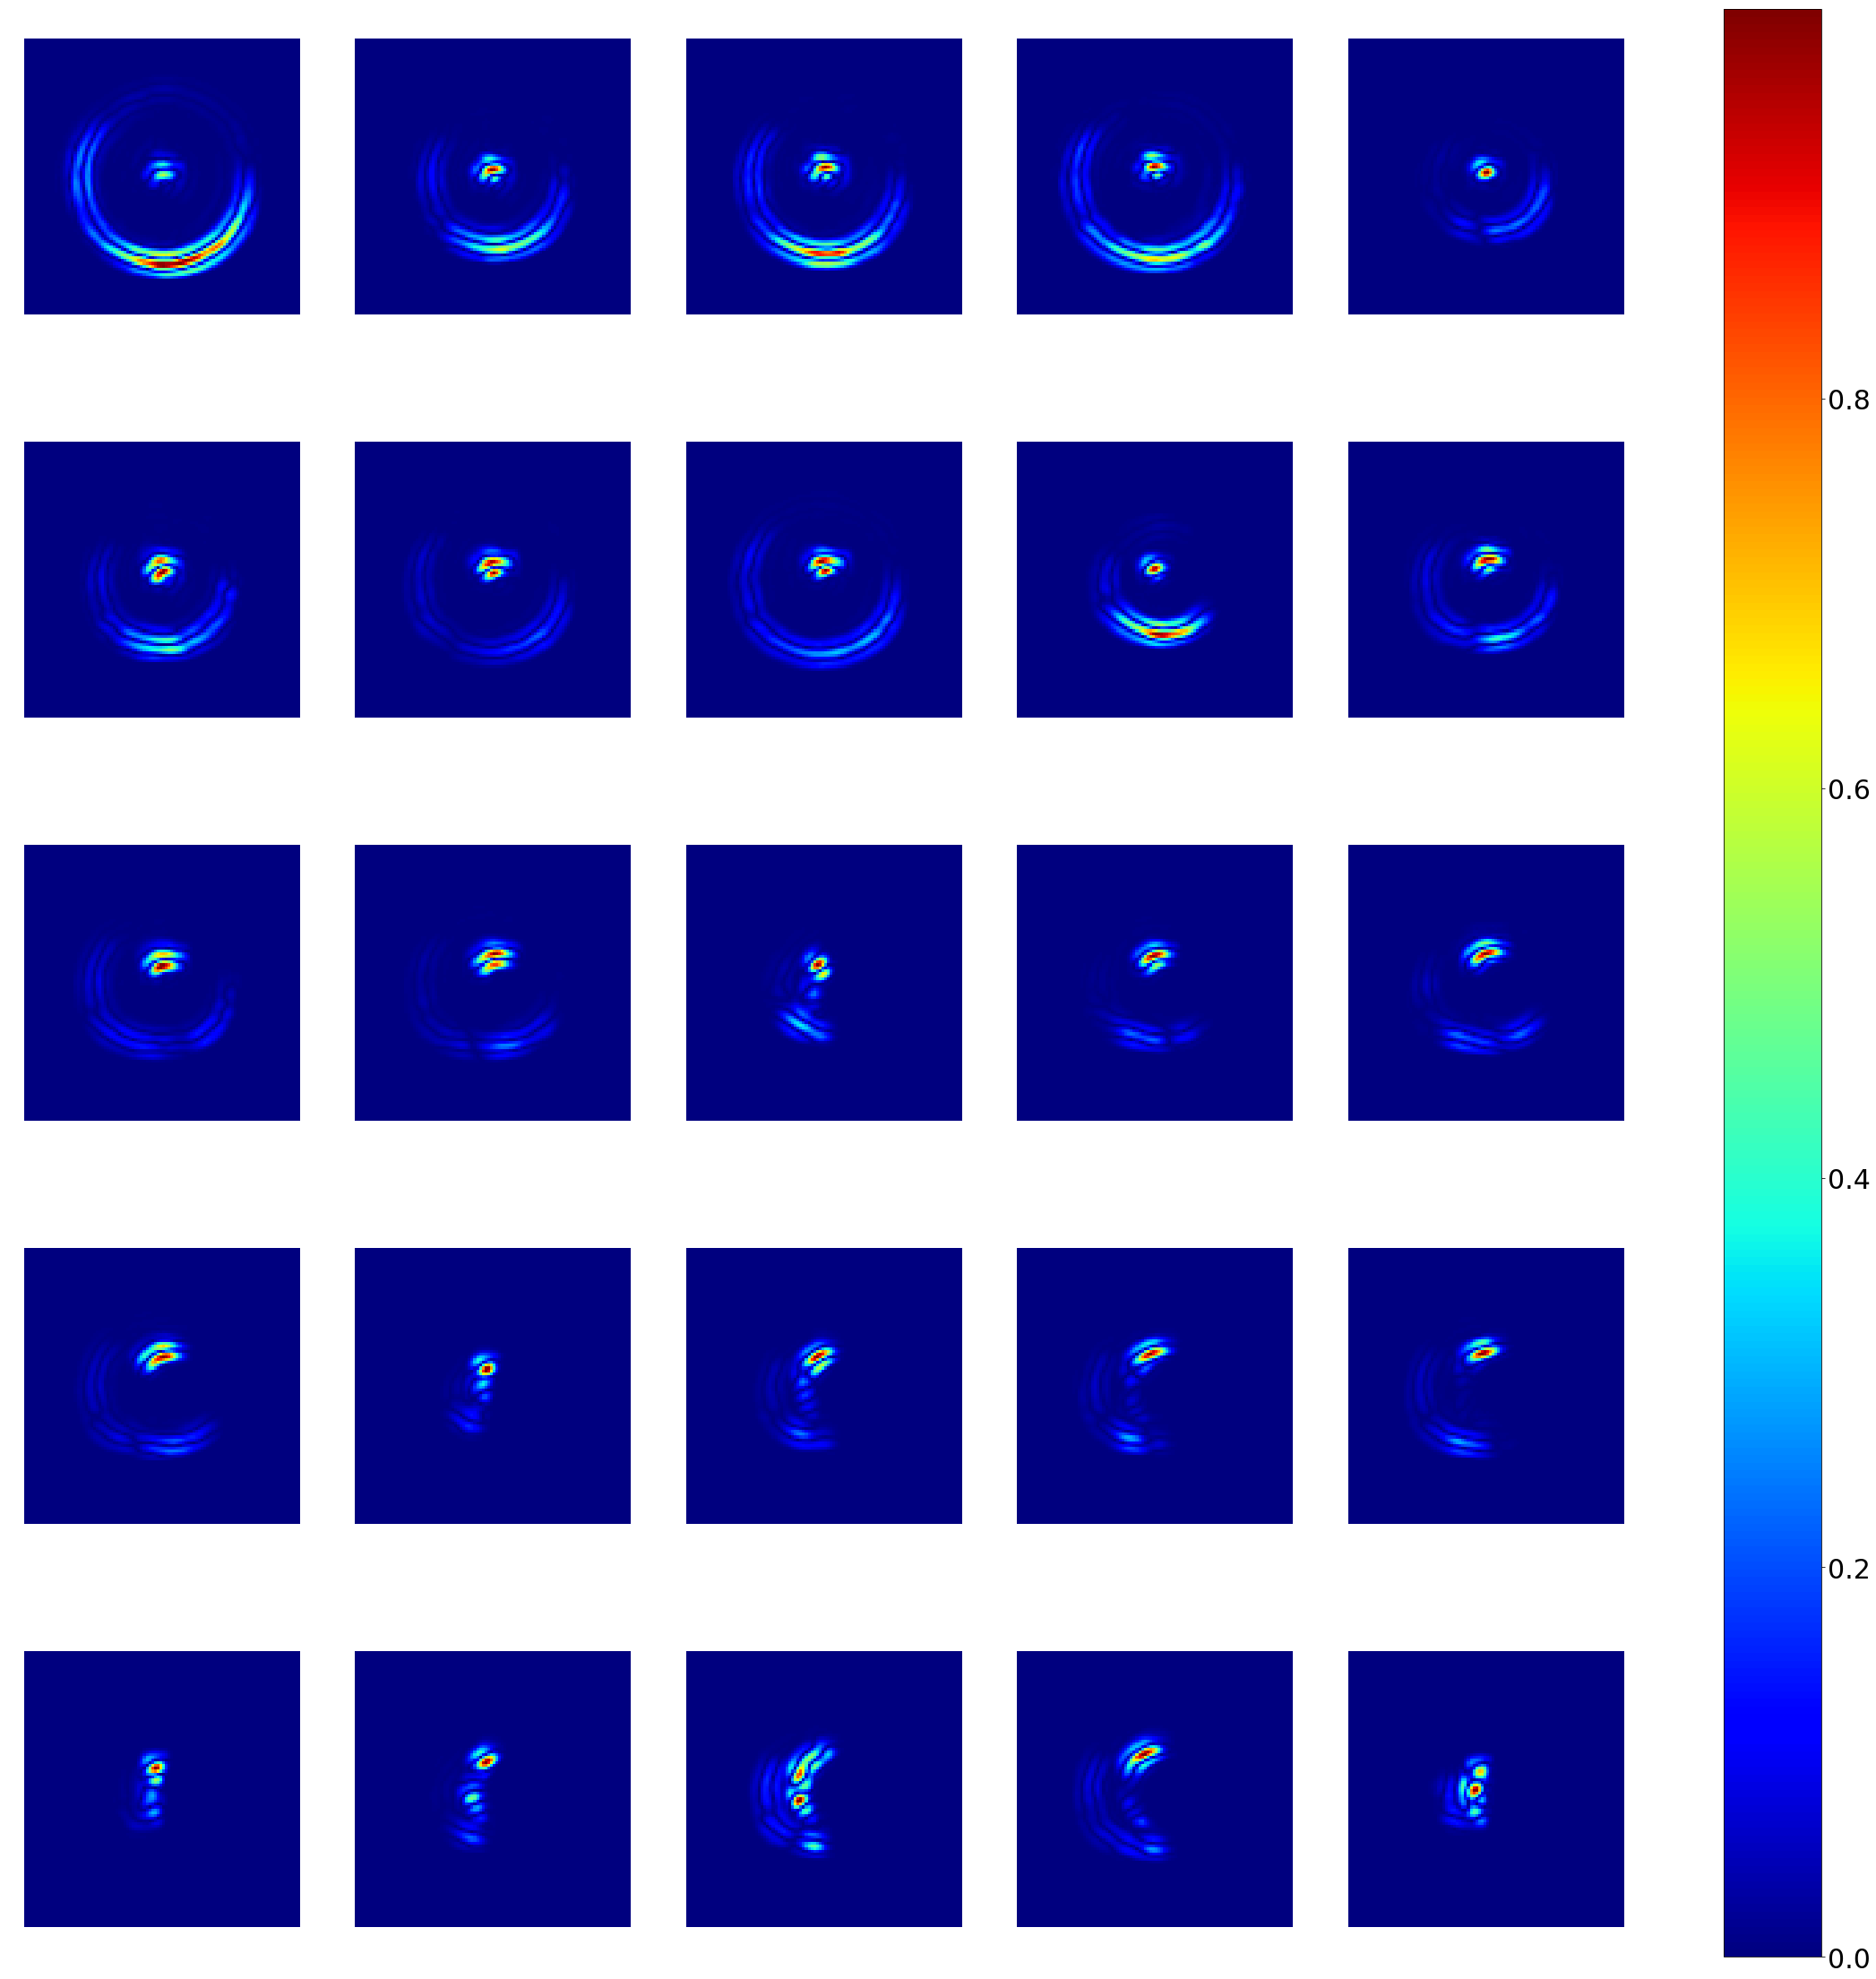

In [78]:
idxs = [int(x) for x in np.linspace(0,9089, 25)]
plt.figure(figsize=(40,40))
axs = []
for i, seed_idx in enumerate(idxs):
    ax1=plt.subplot(5, 5, i+1)
    grads = saliency_map(model, y[seed_idx], X[seed_idx])
    p=ax1.imshow(grads, cmap='jet')
    plt.axis('off')
    axs.append(ax1)
cbar = fig.colorbar(p,ax=axs)
cbar.ax.tick_params(labelsize=30) 
plt.show()

# Maximixing Filter Activation
https://github.com/raghakot/keras-vis/tree/master/examples

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

load model

In [89]:
import keras
from vis.utils import utils
from vis.visualization import visualize_saliency

# Load the model
model_name = 'model1'
yaml_file = open('multiscale_' + model_name + '_weights.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = keras.models.model_from_yaml(loaded_model_yaml)
# load weights into new model
model.load_weights('multiscale_' + model_name + '_weights.h5')

# Swap softmax with linear
model.layers[-1].activation = keras.activations.linear
model = utils.apply_modifications(model)

load data

In [90]:
X_data = np.load("X_data_fits.npy")
y_data = np.load("y_data_fits.npy")

maxmap_arr = np.max(X_data.reshape(X_data.shape[0],-1), axis = 1)
Xnorm = np.tile(maxmap_arr, (X_data.shape[1], X_data.shape[2], 1))
Xnorm = np.swapaxes(Xnorm, 0, 2)
X = X_data/Xnorm
X = X[..., np.newaxis]

y2d = y_data.copy()
y2d[:,0] = y_data[:,0]//20
idx = np.where(y2d[:,0]==5)[0]
y2d[idx,0] = 4
y2d[:,1] = y_data[:,1]//20
y = y2d[:,1]*5 + y2d[:,0]

In [91]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
from vis.input_modifiers import Jitter

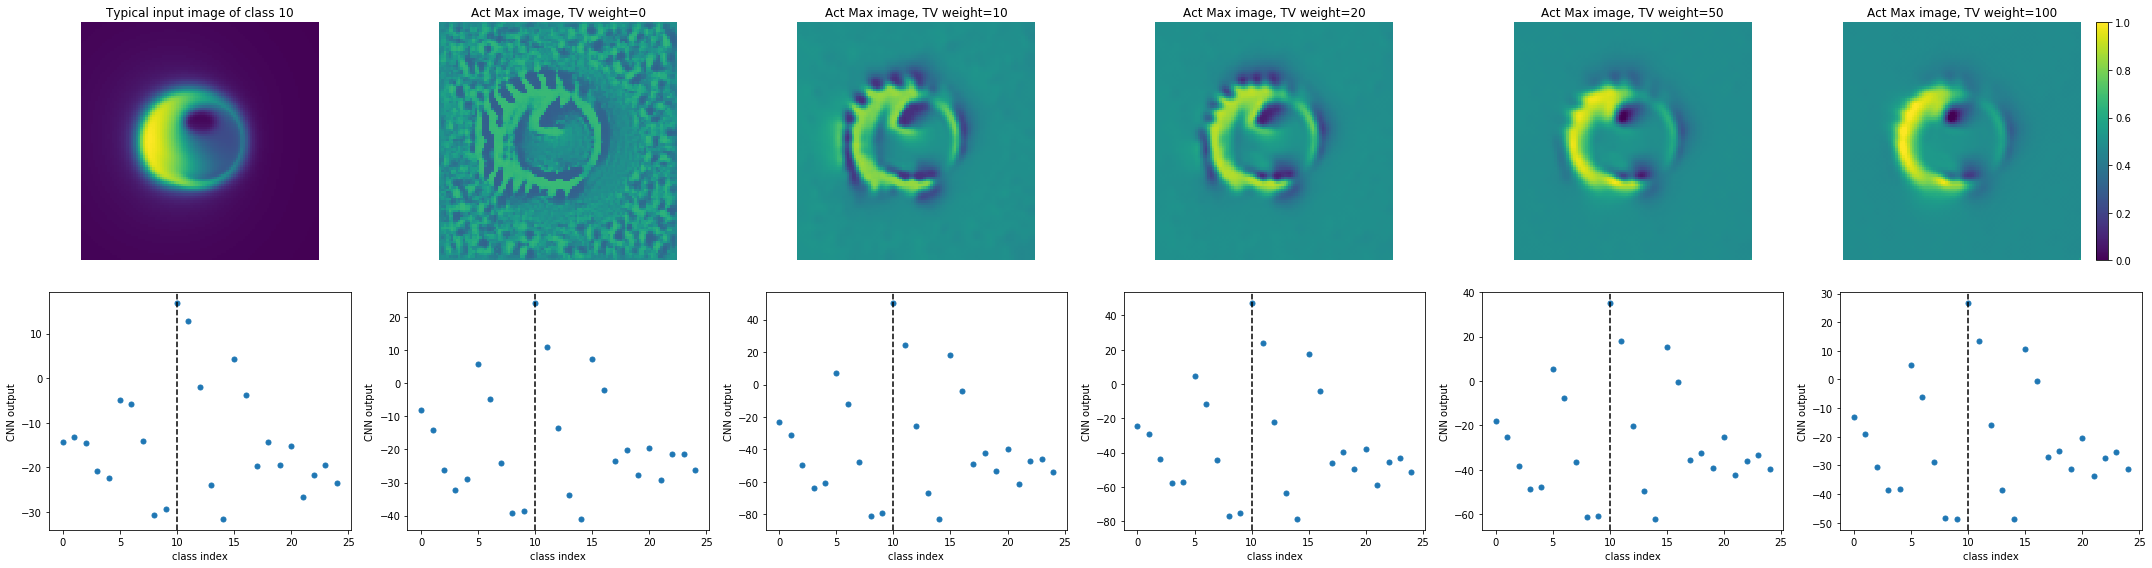

In [92]:
filter_idx = 10
avg_idx =np.mean(y_data[np.where(y==filter_idx)[0],:], axis=0, dtype=int)
idx = np.where(np.logical_and(y_data[:,0] == avg_idx[0], y_data[:,1] == avg_idx[1]))[0][0]

fig, ax = plt.subplots(2,6,figsize=(30,8))
p=ax[0][0].imshow(X[idx].reshape(100,100), vmin=0, vmax=1)
ax[0][0].axis('off')
ax[0][0].set_title('Typical input image of class %d'%filter_idx)
cbar = fig.colorbar(p,ax=ax[0][-1])

ax[1][0].plot(model.predict(X[np.newaxis,idx])[0],'.',markersize=10)
ax[1][0].axvline(filter_idx, color='k', ls='--')
ax[1][0].set_xlabel('class index')
ax[1][0].set_ylabel('CNN output')

for i,tvw in enumerate([0, 10, 20, 50, 100]):
    img = visualize_activation(model, -1,
                               filter_indices=filter_idx,
                               input_range=(0., 1.),
                               tv_weight=tvw,
                               lp_norm_weight=0,
                              )

    avg_idx =np.mean(y_data[np.where(y==filter_idx)[0],:], axis=0, dtype=int)
    idx = np.where(np.logical_and(y_data[:,0] == avg_idx[0], y_data[:,1] == avg_idx[1]))[0][0]


    ax[0][i+1].imshow(img[...,0], vmin=0, vmax=1)
    ax[0][i+1].axis('off')
    ax[0][i+1].set_title('Act Max image, TV weight=%d'%tvw)

    ax[1][i+1].plot(model.predict(img[np.newaxis,...])[0],'.',markersize=10)
    ax[1][i+1].axvline(filter_idx, color='k', ls='--')
    ax[1][i+1].set_xlabel('class index')
    ax[1][i+1].set_ylabel('CNN output')

    plt.tight_layout()
plt.show()    

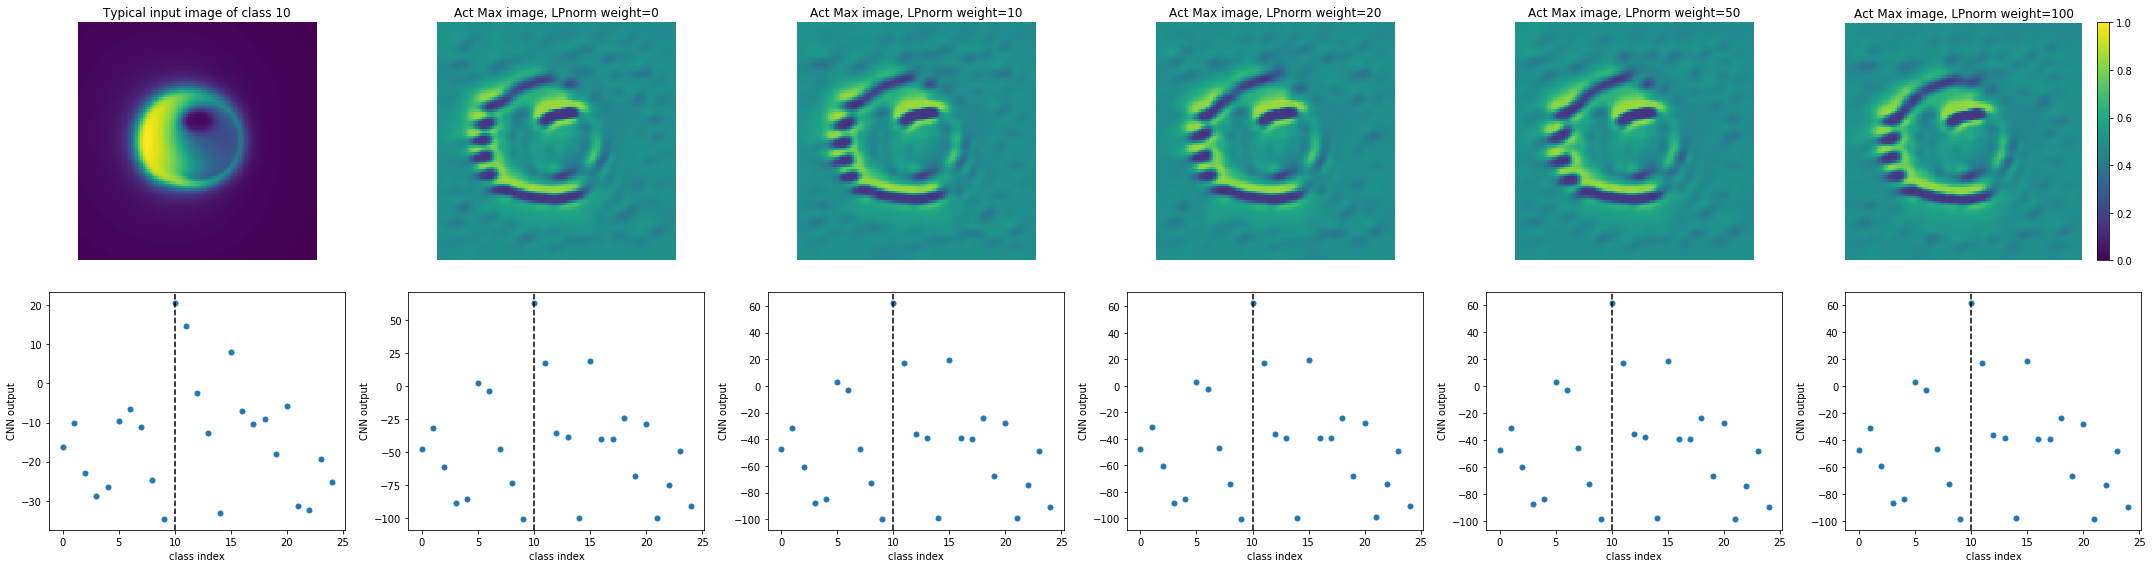

In [84]:
filter_idx = 10
avg_idx =np.mean(y_data[np.where(y==filter_idx)[0],:], axis=0, dtype=int)
idx = np.where(np.logical_and(y_data[:,0] == avg_idx[0], y_data[:,1] == avg_idx[1]))[0][0]

fig, ax = plt.subplots(2,6,figsize=(30,8))
p=ax[0][0].imshow(X[idx].reshape(100,100), vmin=0, vmax=1)
ax[0][0].axis('off')
ax[0][0].set_title('Typical input image of class %d'%filter_idx)
cbar = fig.colorbar(p,ax=ax[0][-1])

ax[1][0].plot(model.predict(X[np.newaxis,idx])[0],'.',markersize=10)
ax[1][0].axvline(filter_idx, color='k', ls='--')
ax[1][0].set_xlabel('class index')
ax[1][0].set_ylabel('CNN output')

for i,lpw in enumerate([0, 10, 20, 50, 100]):
    img = visualize_activation(model, -1,
                               filter_indices=filter_idx,
                               input_range=(0., 1.),
                               tv_weight=10,
                               lp_norm_weight=lpw,
                              )

    avg_idx =np.mean(y_data[np.where(y==filter_idx)[0],:], axis=0, dtype=int)
    idx = np.where(np.logical_and(y_data[:,0] == avg_idx[0], y_data[:,1] == avg_idx[1]))[0][0]


    ax[0][i+1].imshow(img[...,0], vmin=0, vmax=1)
    ax[0][i+1].axis('off')
    ax[0][i+1].set_title('Act Max image, LPnorm weight=%d'%lpw)

    ax[1][i+1].plot(model.predict(img[np.newaxis,...])[0],'.',markersize=10)
    ax[1][i+1].axvline(filter_idx, color='k', ls='--')
    ax[1][i+1].set_xlabel('class index')
    ax[1][i+1].set_ylabel('CNN output')

    plt.tight_layout()
plt.show()

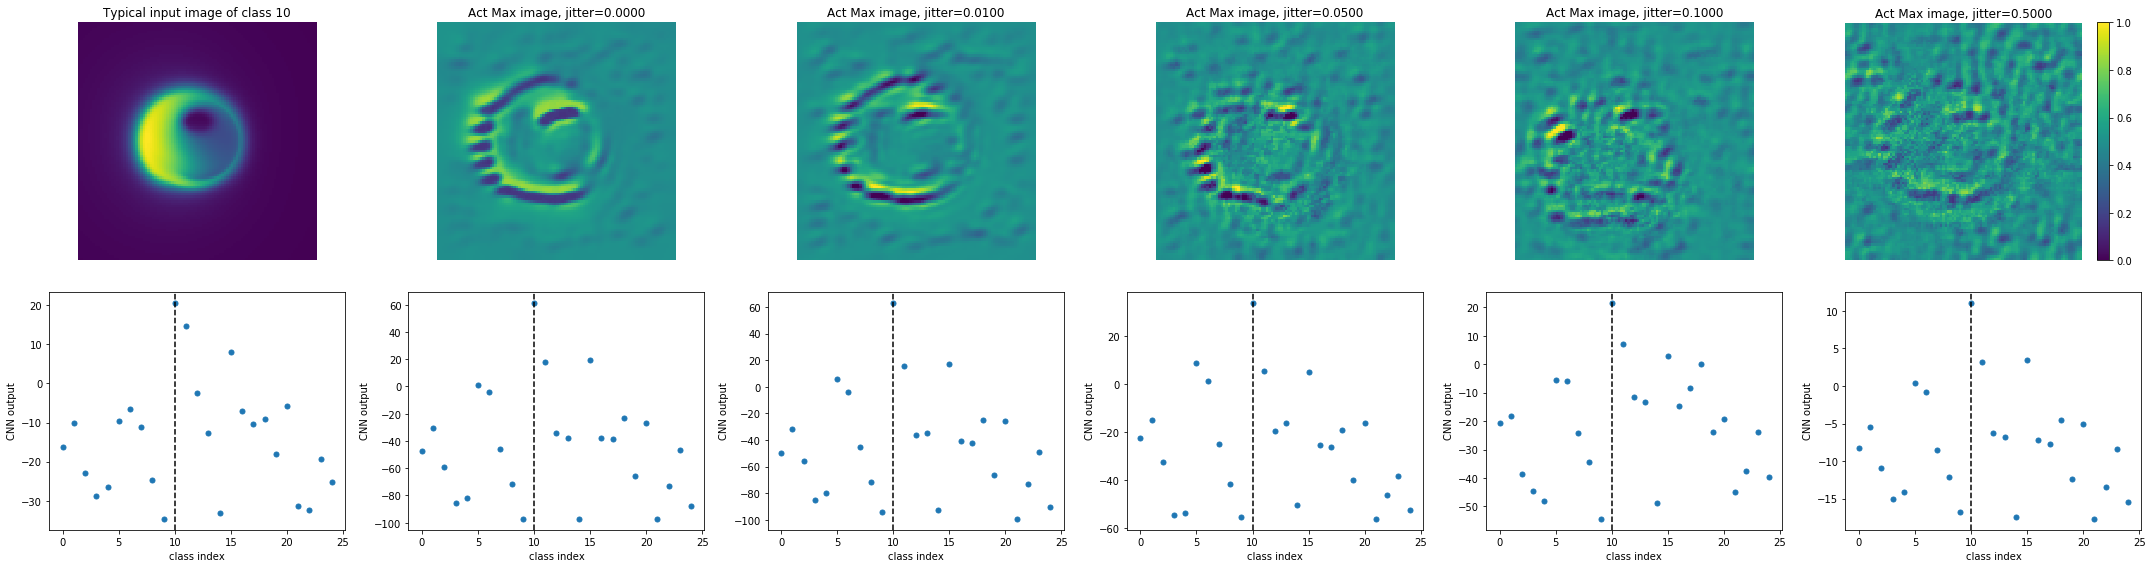

In [85]:
filter_idx = 10
avg_idx =np.mean(y_data[np.where(y==filter_idx)[0],:], axis=0, dtype=int)
idx = np.where(np.logical_and(y_data[:,0] == avg_idx[0], y_data[:,1] == avg_idx[1]))[0][0]

fig, ax = plt.subplots(2,6,figsize=(30,8))
p=ax[0][0].imshow(X[idx].reshape(100,100), vmin=0, vmax=1)
ax[0][0].axis('off')
ax[0][0].set_title('Typical input image of class %d'%filter_idx)
cbar = fig.colorbar(p,ax=ax[0][-1])

ax[1][0].plot(model.predict(X[np.newaxis,idx])[0],'.',markersize=10)
ax[1][0].axvline(filter_idx, color='k', ls='--')
ax[1][0].set_xlabel('class index')
ax[1][0].set_ylabel('CNN output')

for i,jitter in enumerate([0, 0.01, 0.05, 0.1, 0.5]):
    img = visualize_activation(model, -1,
                               filter_indices=filter_idx,
                               input_range=(0., 1.),
                               tv_weight=10,
                               lp_norm_weight=0,
                               input_modifiers=[Jitter(jitter)]
                              )

    avg_idx =np.mean(y_data[np.where(y==filter_idx)[0],:], axis=0, dtype=int)
    idx = np.where(np.logical_and(y_data[:,0] == avg_idx[0], y_data[:,1] == avg_idx[1]))[0][0]


    ax[0][i+1].imshow(img[...,0], vmin=0, vmax=1)
    ax[0][i+1].axis('off')
    ax[0][i+1].set_title('Act Max image, jitter=%.4f'%jitter)

    ax[1][i+1].plot(model.predict(img[np.newaxis,...])[0],'.',markersize=10)
    ax[1][i+1].axvline(filter_idx, color='k', ls='--')
    ax[1][i+1].set_xlabel('class index')
    ax[1][i+1].set_ylabel('CNN output')

    plt.tight_layout()
plt.show()

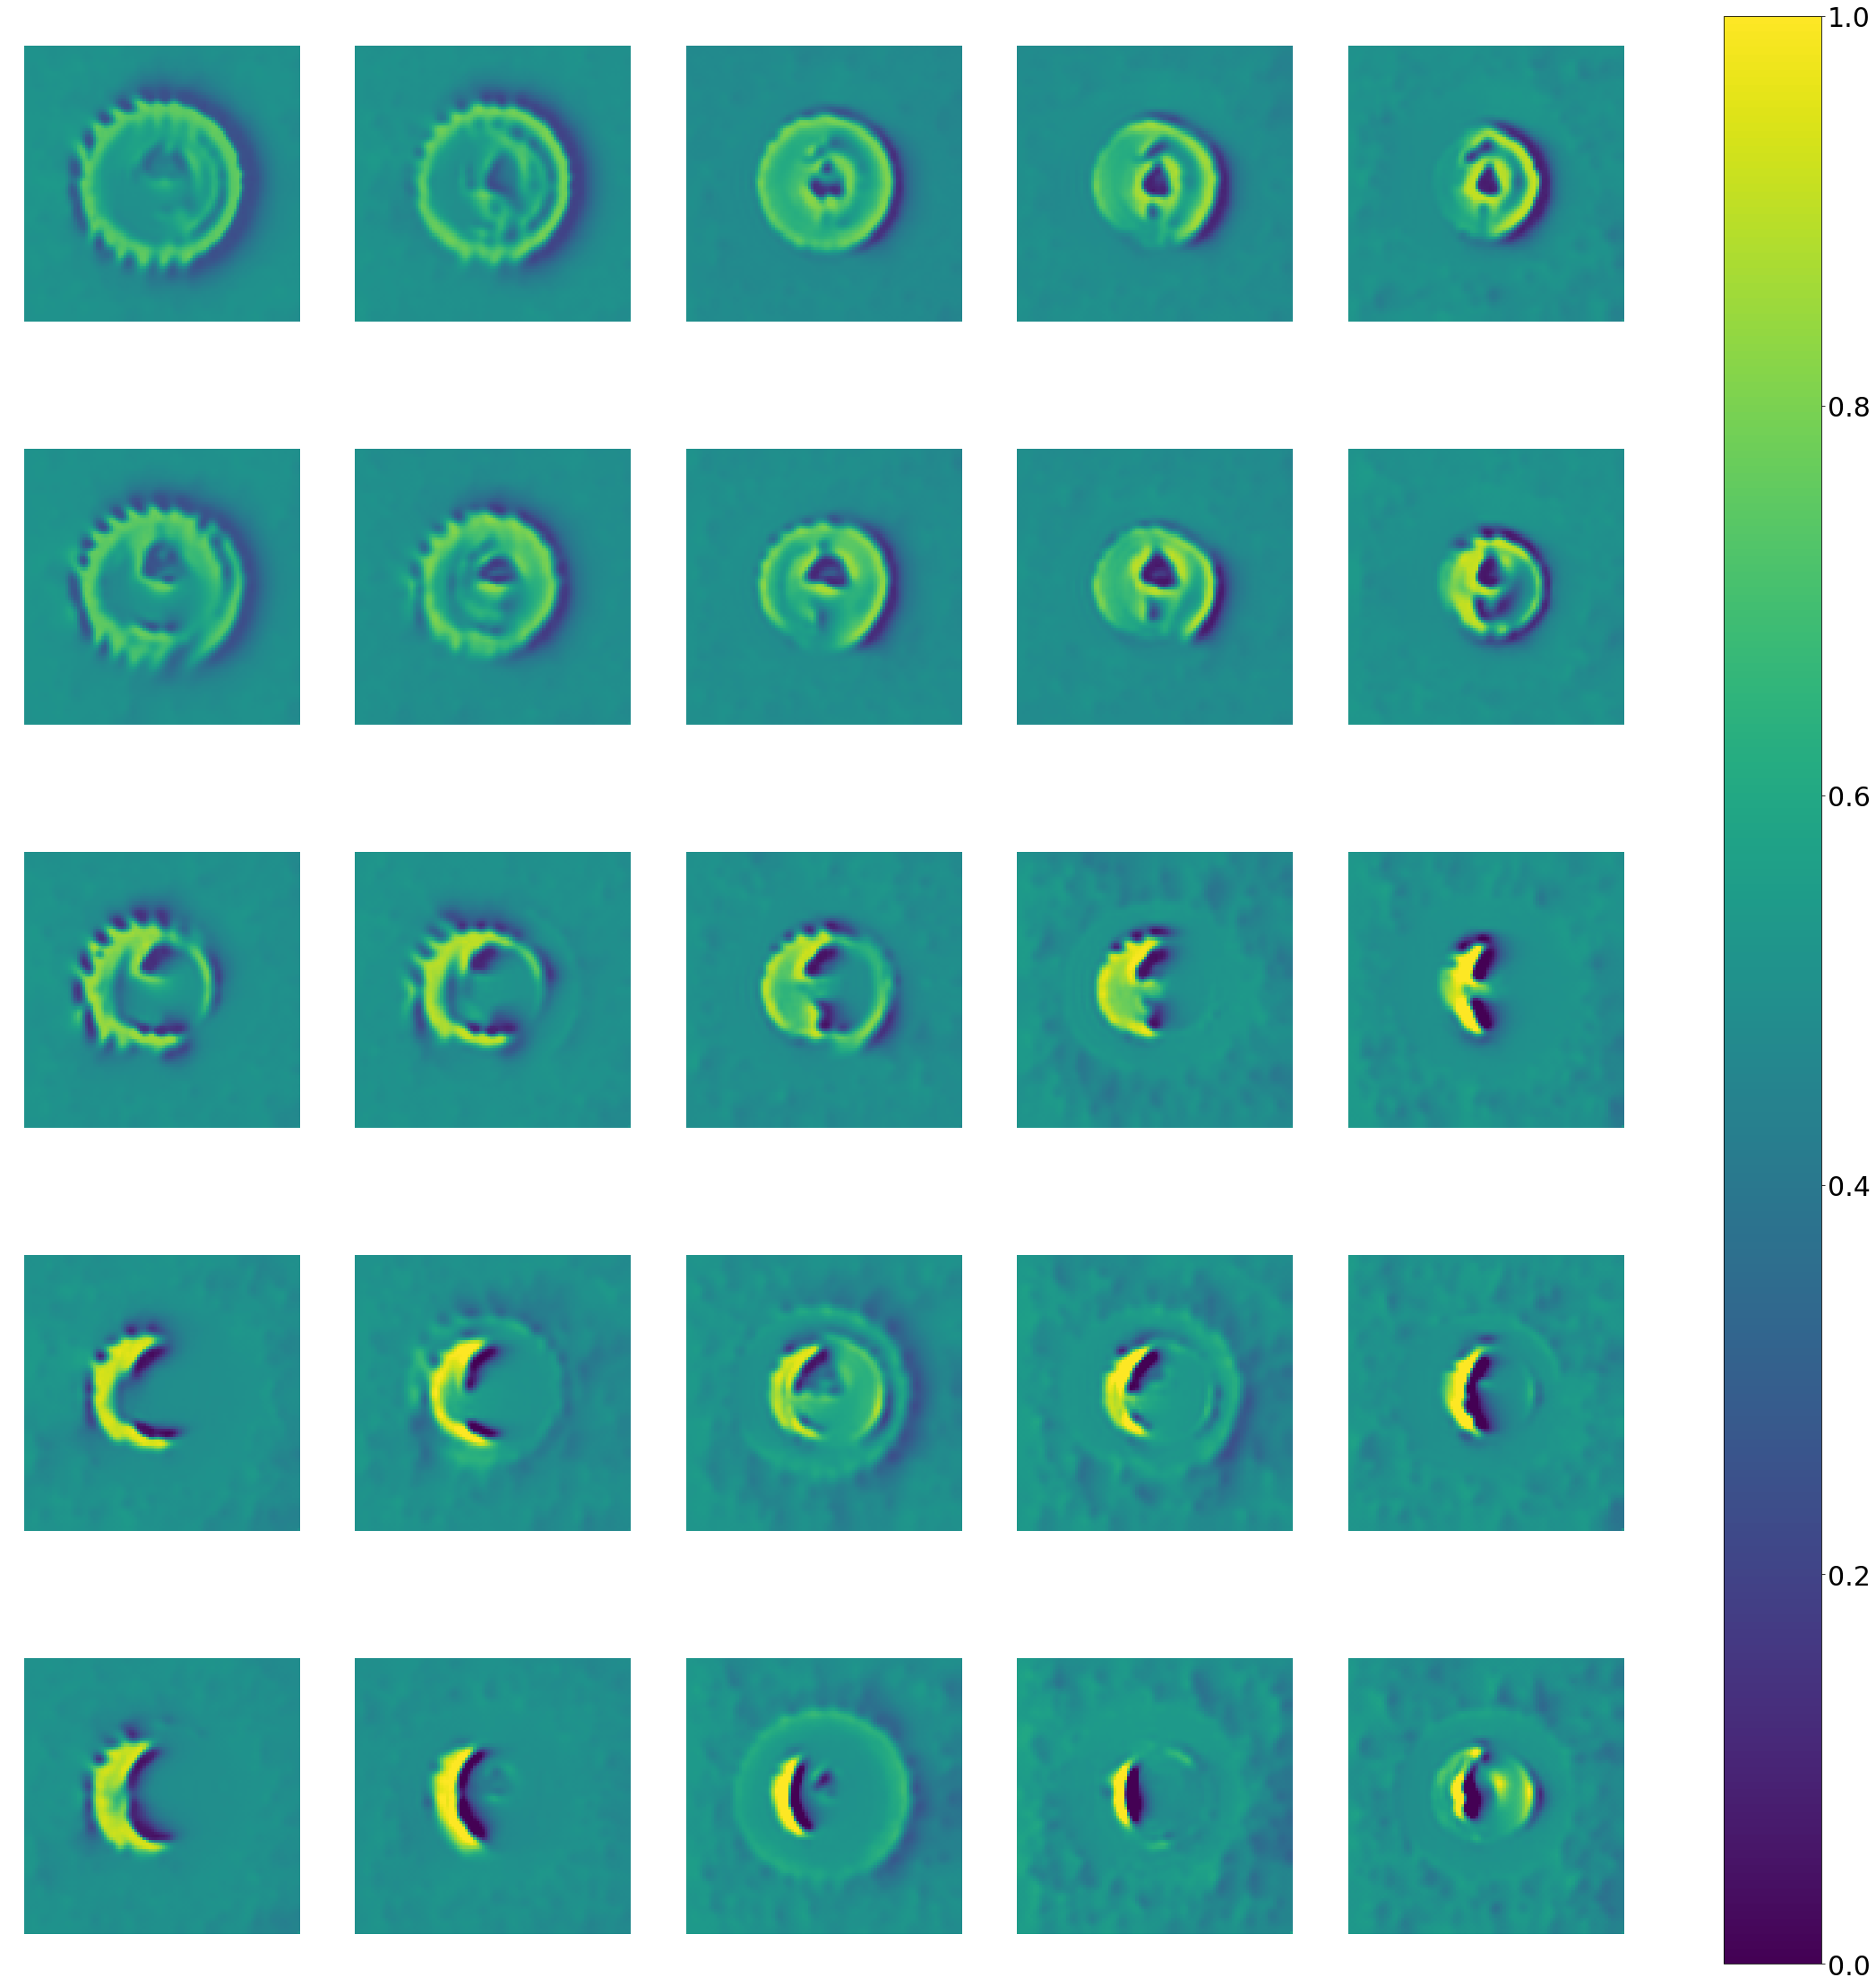

In [93]:
plt.figure(figsize=(40,40))
axs = []
preds = []
for i in range(25):
    ax1=plt.subplot(5, 5, i+1)
    img = visualize_activation(model, -1,
                           filter_indices=i,
                           input_range=(0., 1.),
                           tv_weight=10,
                           lp_norm_weight=0
                              )
    preds.append(model.predict(img[np.newaxis,...])[0])
    p=ax1.imshow(img[...,0], vmin=0, vmax=1)
    plt.axis('off')
    axs.append(ax1)
cbar = fig.colorbar(p,ax=axs)
cbar.ax.tick_params(labelsize=30) 
plt.show()

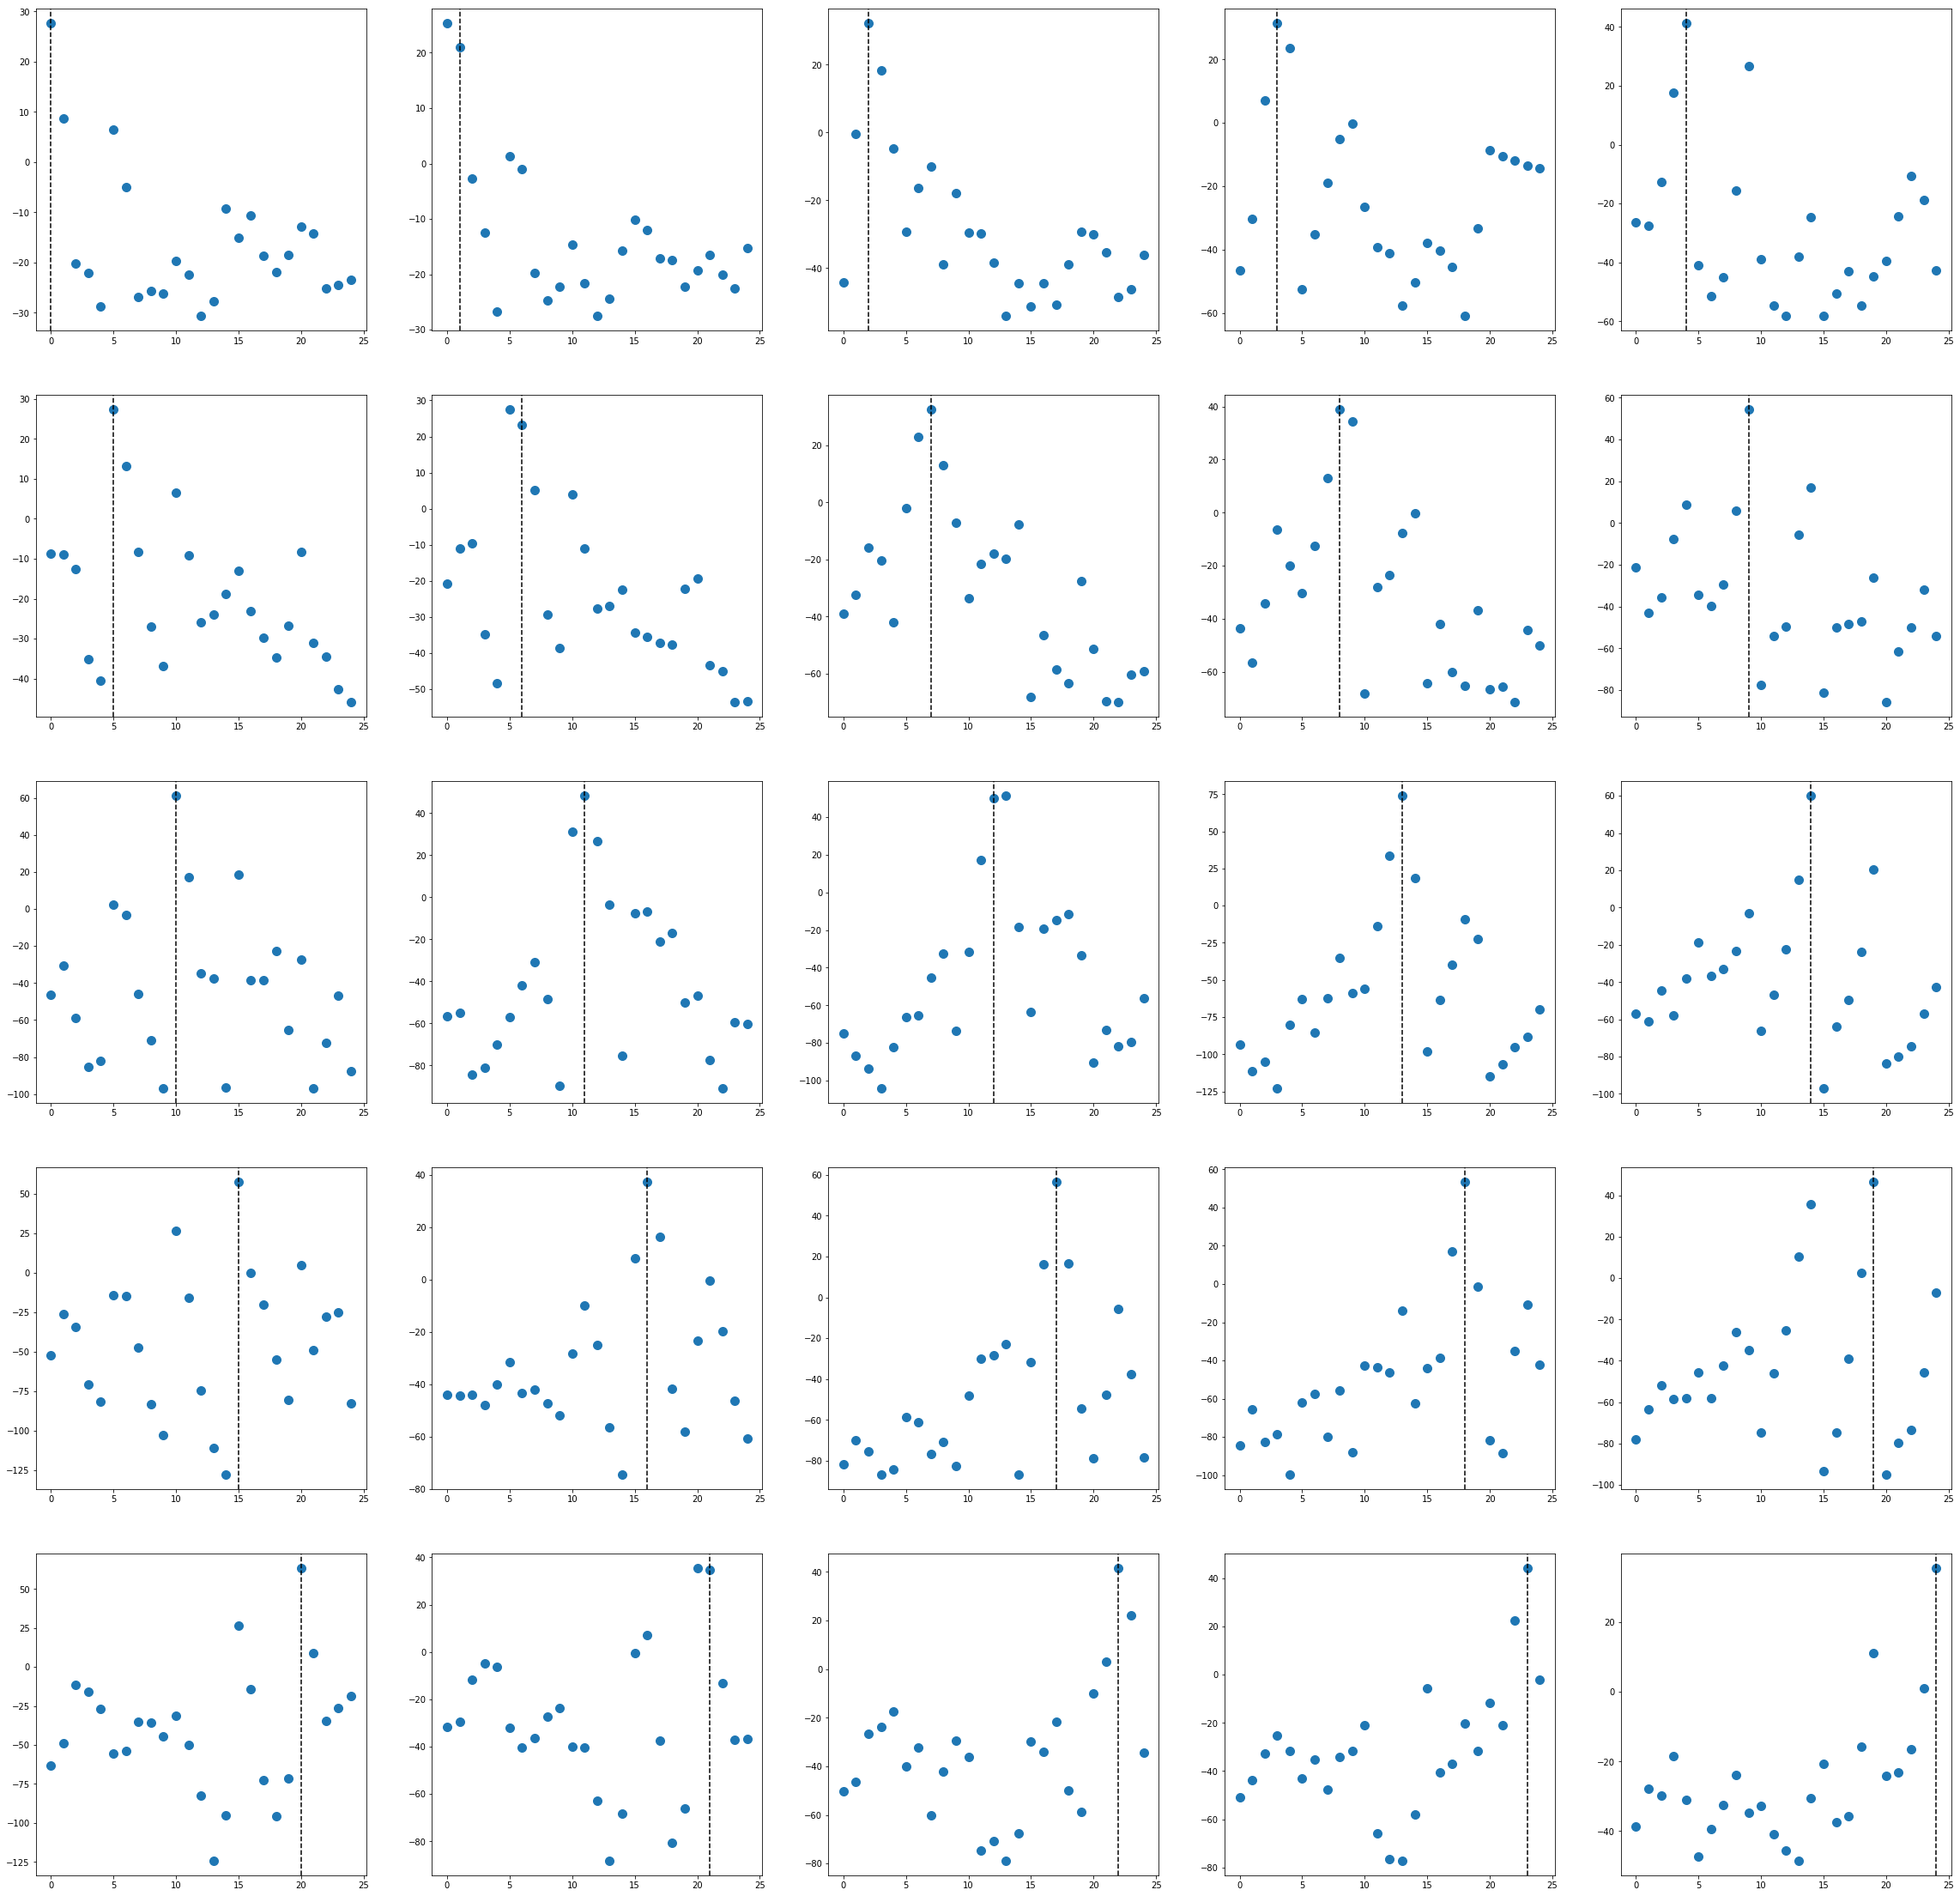

In [87]:
plt.figure(figsize=(40,40))
for i in range(25):
    ax1=plt.subplot(5, 5, i+1)
    ax1.plot(preds[i],'.',markersize=20)
    ax1.axvline(i, color='k', ls='--')
plt.show()

In [70]:
plt.figure(figsize=(40,40))
for i in range(25):
    ax1=plt.subplot(5, 5, i+1)
    avg_idx =np.mean(y_data[np.where(y==i)[0],:], axis=0, dtype=int)
    idx = np.where(np.logical_and(y_data[:,0] == avg_idx[0], y_data[:,1] == avg_idx[1]))[0][0]
    p=ax1.imshow(X[idx].reshape(100,100))
    plt.axis('off')